In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Logistic

In [4]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_and_split_data(root_dir, test_size=0.2):
    #classes = ['untreated', 'single_dose', 'drug_screened']
    classes = ['untreated', 'single_dose']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.tiff')]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"../../Data_supervised"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [5]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0])


In [6]:
def prepare_data_features(dataloader):
    feats, labels = [], []
    
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        
        # Flatten the images from (N, C, H, W) to (N, C*H*W)
        batch_feats = batch_imgs.view(batch_imgs.size(0), -1)  # Flatten the images
        print(f"Batch features shape: {batch_feats.shape}")  # Check the feature shape
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)


In [7]:
# Extract features for train and test datasets
train_feats = prepare_data_features(train_loader_labeled)
test_feats = prepare_data_features(test_loader_labeled)

 33%|███▎      | 1/3 [00:00<00:01,  1.42it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 67%|██████▋   | 2/3 [00:01<00:00,  1.44it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])
Features shape after concatenation: torch.Size([48, 27648])
Labels shape after concatenation: torch.Size([48])


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

Batch features shape: torch.Size([12, 27648])
Batch labels shape: torch.Size([12])
Features shape after concatenation: torch.Size([12, 27648])
Labels shape after concatenation: torch.Size([12])


In [8]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [9]:
# Training function
def train_logistic_regression(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_feats, batch_labels in tqdm(train_loader, desc="Training"):
        batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_feats)
        loss = nn.functional.cross_entropy(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [10]:
# Evaluation function
def evaluate_logistic_regression(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_feats, batch_labels in tqdm(test_loader, desc="Evaluating"):
            batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
            
            outputs = model(batch_feats)
            loss = nn.functional.cross_entropy(outputs, batch_labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [11]:
# Main training loop
def train_logreg_simplified(batch_size, train_feats_data, test_feats_data, feature_dim, num_classes, lr=5e-4, weight_decay=1e-4, max_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0) #num_workers =os.cpu_count()
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Model, loss, and optimizer
    model = LogisticRegression(feature_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[int(max_epochs * 0.6), int(max_epochs * 0.8)],
                                               gamma=0.1)

    # Store metrics for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_test_acc = 0.0
    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")

        train_loss, train_acc = train_logistic_regression(model, train_loader, optimizer, scheduler, device)
        test_loss, test_acc = evaluate_logistic_regression(model, test_loader, criterion, device)
        
        print(f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model.state_dict()

    # Load best model state
    model.load_state_dict(best_model_state)

    # Plot results
    plt.figure(figsize=(15, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(max_epochs), train_losses, label='Train Loss')
    plt.plot(range(max_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(max_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(max_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, {"train_acc": train_acc, "test_acc": test_acc}

Epoch 1/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 85.76it/s]


Training loss: 4.1810, Training accuracy: 0.4167
Test loss: 5.4895, Test accuracy: 0.5000
Epoch 2/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 109.51it/s]


Training loss: 3.7455, Training accuracy: 0.5000
Test loss: 4.3082, Test accuracy: 0.5000
Epoch 3/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 142.80it/s]


Training loss: 4.2586, Training accuracy: 0.5000
Test loss: 3.3659, Test accuracy: 0.5000
Epoch 4/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 141.97it/s]


Training loss: 3.6079, Training accuracy: 0.5000
Test loss: 3.1059, Test accuracy: 0.5000
Epoch 5/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 489.90it/s]


Training loss: 3.2956, Training accuracy: 0.5000
Test loss: 2.7917, Test accuracy: 0.5000
Epoch 6/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 285.02it/s]


Training loss: 2.9580, Training accuracy: 0.5000
Test loss: 2.4457, Test accuracy: 0.5000
Epoch 7/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 248.24it/s]


Training loss: 2.5728, Training accuracy: 0.5000
Test loss: 2.0970, Test accuracy: 0.5000
Epoch 8/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 399.51it/s]


Training loss: 2.2241, Training accuracy: 0.5000
Test loss: 1.7347, Test accuracy: 0.5000
Epoch 9/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 391.06it/s]


Training loss: 1.8100, Training accuracy: 0.5000
Test loss: 1.3957, Test accuracy: 0.5000
Epoch 10/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 498.97it/s]


Training loss: 1.4392, Training accuracy: 0.5000
Test loss: 1.0740, Test accuracy: 0.5000
Epoch 11/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 399.57it/s]


Training loss: 1.1040, Training accuracy: 0.5000
Test loss: 0.7821, Test accuracy: 0.5000
Epoch 12/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 391.17it/s]


Training loss: 0.7787, Training accuracy: 0.5000
Test loss: 0.5566, Test accuracy: 0.5000
Epoch 13/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 489.53it/s]


Training loss: 0.5801, Training accuracy: 0.5208
Test loss: 0.3909, Test accuracy: 0.6667
Epoch 14/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 396.25it/s]


Training loss: 0.3979, Training accuracy: 0.7708
Test loss: 0.3073, Test accuracy: 1.0000
Epoch 15/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 392.67it/s]


Training loss: 0.3312, Training accuracy: 0.9583
Test loss: 0.2739, Test accuracy: 1.0000
Epoch 16/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 400.39it/s]


Training loss: 0.3006, Training accuracy: 1.0000
Test loss: 0.2698, Test accuracy: 1.0000
Epoch 17/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 501.41it/s]


Training loss: 0.2997, Training accuracy: 1.0000
Test loss: 0.2747, Test accuracy: 1.0000
Epoch 18/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 285.73it/s]


Training loss: 0.2976, Training accuracy: 1.0000
Test loss: 0.2764, Test accuracy: 1.0000
Epoch 19/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 389.64it/s]


Training loss: 0.2970, Training accuracy: 1.0000
Test loss: 0.2742, Test accuracy: 1.0000
Epoch 20/20


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 309.57it/s]


Training loss: 0.2948, Training accuracy: 1.0000
Test loss: 0.2710, Test accuracy: 1.0000


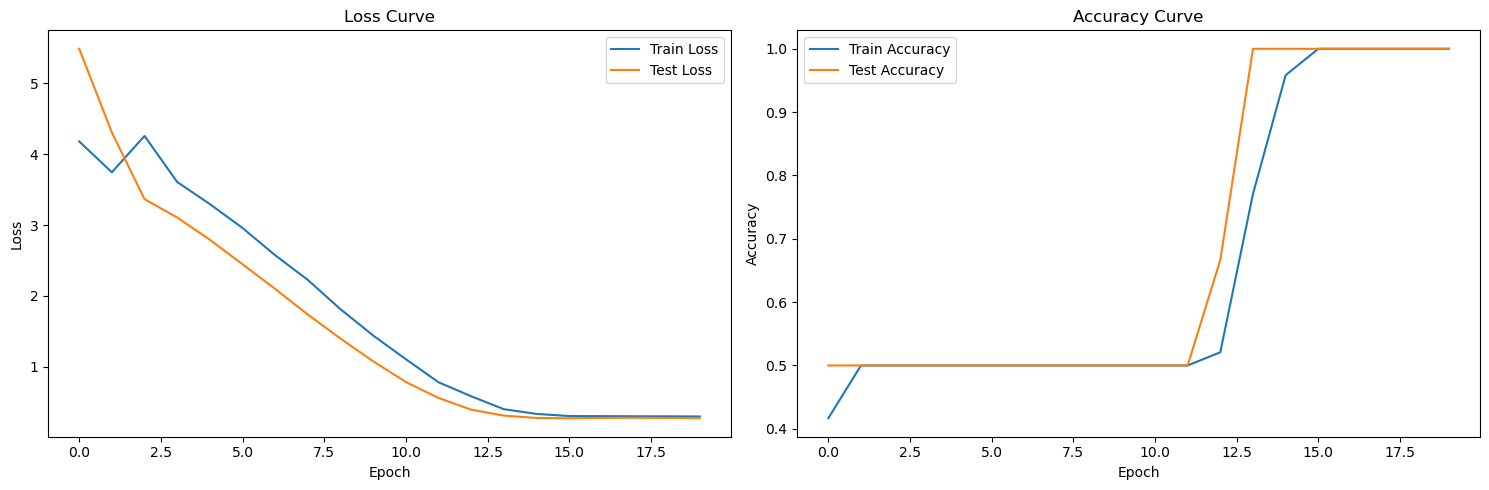

In [12]:
# Train the logistic regression model
logreg_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats,
    test_feats_data=test_feats,
    feature_dim=train_feats.tensors[0].shape[1],
    num_classes=2,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=20
)

#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


In [13]:
train_feats.tensors[0].shape[1]

27648